In [43]:
from sklearn.datasets import make_classification
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from src.models import BaseAutoEncoder

In [2]:
from copy import deepcopy
import numpy as np
import torch
import wandb
from torch.utils.data import DataLoader
from src.dataload.window_based import WindowBasedDataset, WeightedWindowBasedDataset
from src.dataload.tabular import tabularDataset, WeightedtabularDataset


def _softmax(recon_error):
    exp_recon_error = np.exp(recon_error - np.max(recon_error))
    return exp_recon_error / np.sum(exp_recon_error)


def _cal_sample_weight(recon_error):
    sample_weight = 1 - _softmax(recon_error)
    sample_weight = sample_weight / np.sum(sample_weight)
    return sample_weight


class BaseTrainer:
    def __init__(self, model, optimizer, crit):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.crit = crit

    def _train(self, train_loader, device):
        self.model.train()
        total_loss = 0
        for input_x, _ in train_loader:
            if device != "cpu":
                input_x = input_x.to(device)
                output_x = input_x.to(device)
            y_hat = self.model(input_x)
            loss = self.crit(y_hat, output_x)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            # prevent memory leak
            total_loss += float(loss)
        return total_loss / len(train_loader)

    def _validate(self, val_loader, device):
        self.model.eval()
        with torch.no_grad():
            total_loss = 0
            for input_x, _ in val_loader:
                if device != "cpu":
                    input_x = input_x.to(device)
                    output_x = input_x.to(device)
                y_hat = self.model(input_x)
                loss = self.crit(y_hat, output_x)
                # prevent memory leak
                total_loss += float(loss)
            return total_loss / len(val_loader)

    def train(self, train_loader, val_loader, config, use_wandb):
        lowest_train_loss = np.inf
        lowest_val_loss = np.inf
        best_model = None
        early_stop_round = 0
        return_epoch = 0

        if use_wandb:
            wandb.login()
            wandb.init(project=config.project, config=config)
            wandb.watch(self.model, self.crit, log="gradients", log_freq=100)

        for epoch_index in range(config.n_epochs):
            train_loss = self._train(train_loader, config.device)
            valid_loss = self._validate(val_loader, config.device)

            if use_wandb:
                wandb.log({"train_loss": train_loss})
                wandb.log({"valid_loss": valid_loss})

            if valid_loss < lowest_val_loss:
                lowest_train_loss = train_loss
                lowest_val_loss = valid_loss
                best_model = deepcopy(self.model.state_dict())
                early_stop_round = 0
            else:
                early_stop_round += 1
            if early_stop_round == config.early_stop_round:
                print(f"Early Stopped! in Epoch {epoch_index + 1}:")
                print(f"train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}")
                return_epoch = epoch_index
                break
            if (epoch_index + 1) % 10 == 0:
                print(f"Epoch {epoch_index+1}/{config.n_epochs}:")
                print(f"train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}")
            return_epoch = epoch_index
        self.model.load_state_dict(best_model)
        return lowest_train_loss, lowest_val_loss, return_epoch, self.model


class NewTrainer:
    def __init__(self, model, optimizer, crit):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.crit = crit

    def _train(self, train_loader, device):
        self.model.train()
        total_loss = 0
        for input_x, _ in train_loader:
            if device != "cpu":
                input_x = input_x.to(device)
                output_x = input_x.to(device)
            y_hat = self.model(input_x)
            loss = self.crit(y_hat, output_x)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += float(loss)
        return total_loss / len(train_loader)

    def _validate(self, val_loader, device):
        self.model.eval()
        with torch.no_grad():
            total_loss = 0
            for input_x, _ in val_loader:
                if device != "cpu":
                    input_x = input_x.to(device)
                    output_x = input_x.to(device)
                y_hat = self.model(input_x)
                loss = self.crit(y_hat, output_x)
                # prevent memory leak
                total_loss += float(loss)
            return total_loss / len(val_loader)

    def _inference(self, train_loader, train_recon_error, config):
        self.model.eval()
        idx = 0
        with torch.no_grad():
            for input_x, _ in train_loader:
                input_x_batch_size = input_x.shape[0]
                if config.device != "cpu":
                    input_x = input_x.to(config.device)
                y_hat = self.model(input_x)
                # calculate train recon error
                anomaly_score = abs(input_x - y_hat)
                mean_anomaly_score = (
                    torch.mean(anomaly_score, 1).detach().to("cpu").numpy()
                )
                train_recon_error[idx : idx + input_x_batch_size] = mean_anomaly_score
                idx += input_x_batch_size
        return train_recon_error

    def train(
        self,
        train_x,
        train_y,
        train_loader,
        val_loader,
        sampling_term,
        config,
        use_wandb,
    ):
        lowest_train_loss = np.inf
        lowest_val_loss = np.inf
        best_model = None
        early_stop_round = 0
        return_epoch = 0

        if config.data == "tabular":
            data_len = len(train_x)
        else:
            data_len = len(train_x) - config.window_size + 1
        train_recon_error = np.zeros(data_len)

        if use_wandb:
            wandb.login()
            wandb.init(project=config.project, config=config)
            wandb.watch(self.model, self.crit, log="gradients", log_freq=100)

        for epoch_index in range(config.n_epochs):
            # sampling
            if (epoch_index >= config.initial_epochs - 1) and (
                epoch_index % sampling_term == 0
            ):
                train_loss = self._train(train_loader, config.device)
                valid_loss = self._validate(val_loader, config.device)

                # calculate weight
                ## make dataloader for inference
                if config.data == "tabular":
                    train_dataset = tabularDataset(train_x, train_y)
                else:
                    train_dataset = WindowBasedDataset(
                        train_x, train_y, config.window_size
                    )
                train_loader_for_inference = DataLoader(
                    train_dataset, shuffle=False, batch_size=config.batch_size
                )
                ## inference to get train reconstruction error
                train_recon_error = self._inference(
                    train_loader_for_inference, train_recon_error, config
                )
                ## calculdate sample weight
                sample_weight = _cal_sample_weight(train_recon_error)

                # sampling with weight
                if config.data == "tabular":
                    train_dataset = WeightedtabularDataset(
                        train_x, train_y, sample_weight
                    )
                else:
                    train_dataset = WeightedWindowBasedDataset(
                        train_x, train_y, config.window_size, sample_weight
                    )
                train_loader = DataLoader(
                    train_dataset, shuffle=False, batch_size=config.batch_size
                )
            # no sampling
            else:
                train_loss = self._train(train_loader, config.device)
                valid_loss = self._validate(val_loader, config.device)

            if use_wandb:
                wandb.log({"train_loss": train_loss})
                wandb.log({"valid_loss": valid_loss})

            if valid_loss < lowest_val_loss:
                lowest_train_loss = train_loss
                lowest_val_loss = valid_loss
                best_model = deepcopy(self.model.state_dict())
                early_stop_round = 0
            else:
                early_stop_round += 1
            if early_stop_round == config.early_stop_round:
                print(f"Early Stopped! in Epoch {epoch_index + 1}:")
                print(f"train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}")
                return_epoch = epoch_index
                break
            if (epoch_index + 1) % 10 == 0:
                print(f"Epoch {epoch_index+1}/{config.n_epochs}:")
                print(f"train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}")
            return_epoch = epoch_index
        self.model.load_state_dict(best_model)
        return lowest_train_loss, lowest_val_loss, return_epoch, self.model

In [40]:
X, y = make_classification(n_samples=5000, n_features=8, n_informative=8, n_redundant=0,  n_classes=2, weights=[0.9,0.1], random_state=0)

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

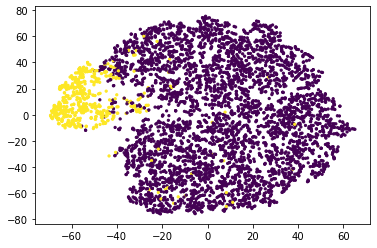

In [42]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=5)

- train은 일단 early_stop 으로 진행
- sampling 할 때
  - weight 저장
  - 빠지는 sampling들 저장

In [ ]:
torch.backends.cudnn.deterministic = True
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [ ]:
PATH = "../tabular_data/"
file_list = os.listdir(PATH)
file_list_csv = [file for file in file_list if file.endswith(".csv")]

for file_name in file_list_csv:
    PATH = "../tabular_data/"
    config.data_name = file_name.split(".")[0]

    (
        train_x,
        valid_x,
        test_x,
        train_y,
        valid_y,
        test_y,
    ) = split_train_valid_test_tabular(PATH, config.data_name, config.train_ratio)
    # resize 'window_size' = 'col_len'
    config.window_size = train_x.shape[1]

    train_dataset = tabularDataset(train_x, train_y)
    valid_dataset = tabularDataset(valid_x, valid_y)

    train_dataloader = DataLoader(
        train_dataset, shuffle=False, batch_size=config.batch_size
    )
    valid_dataloader = DataLoader(
        valid_dataset, shuffle=False, batch_size=config.batch_size
    )

    total_x = np.concatenate([train_x, valid_x, test_x])
    total_y = np.concatenate([train_y, valid_y, test_y])
    IR = round((len(total_y) - np.sum(total_y)) / np.sum(total_y), 4)
    # for inference
    total_dataset = tabularDataset(total_x, total_y)
    total_dataloader = DataLoader(
        total_dataset, shuffle=False, batch_size=config.batch_size
    )

    for hidden_size in config.hidden_size:
        print(f"-----BaseTrainer starts with hidden_size={hidden_size}-----")
        config.trainer_name = "BaseTrainer"

        model = BaseSeq2Seq(
            input_size=config.window_size,
            hidden_size=hidden_size,
            output_size=config.window_size,
            dropout_p=0.2,
        ).to(config.device)

        optimizer = optim.Adam(model.parameters())
        criterion = nn.MSELoss()

        # train
        trainer = BaseTrainer(model=model, optimizer=optimizer, crit=criterion)

        train_loss, val_loss, return_epoch, best_model = trainer.train(
            train_loader=train_dataloader,
            val_loader=valid_dataloader,
            config=config,
            use_wandb=False,
        )

        best_model.to("cpu")
        sampling_term = 0

        df = inference(
            config,
            total_dataloader,
            best_model,
            train_x,
            valid_x,
            total_x,
            total_y,
            return_epoch,
            hidden_size,
            train_loss,
            val_loss,
            IR,
            sampling_term,
        )

        PATH = "../run_results_tabular/"
        df.to_csv(PATH + "result_" + config.data_name + ".csv", index=False)